BASELINE CNN MODEL - DEEPFAKE DETECTION

Section 1: Setup & Environment
├── Install packages
├── Imports
├── Mount Drive
└── Set device (GPU/CPU)

Section 2: Load & Prepare Data
├── Extract zip file
├── Load X and y tensors
├── Shuffle data (with seed)
├── Train/Val/Test split
└── Create DataLoaders

Section 3: Exploratory Data Analysis (EDA)
├── Data distribution visualization
├── Sample images grid
├── Pixel statistics
└── Channel analysis

Section 4: Model Architecture
├── Define CNN backbone
├── Define MLP classifier
├── Model summary
└── Loss function & optimizer

Section 5: Training with Checkpoints
├── Training loop
├── Checkpoint saving (every 10k samples)
├── Loss/accuracy tracking
└── Progress visualization

Section 6: Evaluation & Testing
├── Load best model
├── Test set evaluation
├── Confusion matrix
├── ROC curve
├── Precision/Recall
└── Sample predictions

Section 7: Results Analysis
├── Misclassification analysis
├── Confidence distribution
└── Final summary

---

# SECTION 1: Setup & Environment


## Cell 1.1: Install Packages

In [1]:
# Uncomment if needed:
# !pip install -q torch torchvision scikit-learn matplotlib seaborn

## Cell 1.2: Import Libraries

In [2]:
# Standard libraries
import os
import random
import numpy as np
import zipfile
from pathlib import Path

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix
)

# Misc
from tqdm import tqdm
import time

print("All libraries imported successfully!")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True


---

## Cell 1.3: Set Random Seeds


In [3]:
# Set random seeds for reproducibility
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Cell 1.4: Mount Google Drive


In [4]:
#!pwd

In [5]:
#!ls /content/drive/MyDrive/'NEU - MS CS'/3_SEM/'CS - 7150 (DeepLearning)'/midterm-proj-1/data/

In [6]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

print("✅ Google Drive mounted successfully!")

# Define path to your zip file (no quotes around folder names!)
ZIP_PATH = '/content/drive/MyDrive/NEU - MS CS/3_SEM/CS - 7150 (DeepLearning)/midterm-proj-1/data/faceforensics_dataset.zip'

# Check if file exists
if os.path.exists(ZIP_PATH):
    file_size = os.path.getsize(ZIP_PATH) / (1024**3)  # GB
    print(f"✅ Found dataset: {os.path.basename(ZIP_PATH)}")
    print(f"   Size: {file_size:.2f} GB")
else:
    print(f"❌ File not found: {ZIP_PATH}")
    print(f"   Please check the path!")

Mounted at /content/drive
✅ Google Drive mounted successfully!
✅ Found dataset: faceforensics_dataset.zip
   Size: 1.35 GB


## Cell 1.5: Set Device (GPU/CPU)


In [7]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"🖥️ Device Configuration:")
print(f"   Device: {device}")

if device.type == 'cuda':
    print(f"   GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")
    print(f"   ✅ Using GPU for training!")
else:
    print(f"   ⚠️ GPU not available, using CPU")
    print(f"   Note: Training will be much slower on CPU")

🖥️ Device Configuration:
   Device: cuda
   GPU Name: Tesla T4
   GPU Memory: 14.74 GB
   ✅ Using GPU for training!


## Cell 1.6: Configuration

In [8]:
# Training configuration
CONFIG = {
    # Data
    'batch_size': 64,              # Number of samples per batch
    'num_workers': 2,              # Parallel data loading (2 for Colab)

    # Training
    'num_epochs': 10,              # Total training epochs
    'learning_rate': 0.001,        # Learning rate for optimizer

    # Checkpoints
    'checkpoint_interval': 10000,  # Save checkpoint every 10k samples
    'save_dir': '/content/drive/MyDrive/NEU - MS CS/3_SEM/CS - 7150 (Deep Learning)/midterm-proj-1/models',

    # Data split
    'train_size': 90000,           # 90k for training
    'test_size': 10000,            # 10k for testing

    # Model
    'input_channels': 3,           # RGB images
    'image_size': 64,              # 64x64 images
    'num_classes': 2,              # Binary: Real vs Fake
}

# Create save directory if it doesn't exist
os.makedirs(CONFIG['save_dir'], exist_ok=True)

print("📋 Configuration:")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")

print(f"\n✅ Configuration set!")

📋 Configuration:
   batch_size: 64
   num_workers: 2
   num_epochs: 10
   learning_rate: 0.001
   checkpoint_interval: 10000
   save_dir: /content/drive/MyDrive/NEU - MS CS/3_SEM/CS - 7150 (Deep Learning)/midterm-proj-1/models
   train_size: 90000
   test_size: 10000
   input_channels: 3
   image_size: 64
   num_classes: 2

✅ Configuration set!


---

# SECTION 2: Load & Prepare Data

## Cell 2.1: Extract Zip File

In [9]:
# Define extraction directory
EXTRACT_DIR = '/content/extracted_data'

# Create directory if it doesn't exist
os.makedirs(EXTRACT_DIR, exist_ok=True)

print(f"📂 Extracting to: {EXTRACT_DIR}")
print(f"⏳ This may take a moment...")

start_time = time.time()

# Extract zip file
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(EXTRACT_DIR)

elapsed = time.time() - start_time

print(f"✅ Extraction complete in {elapsed:.2f} seconds")

# List extracted files
print(f"\n📄 Extracted files:")
extracted_files = os.listdir(EXTRACT_DIR)
for file in extracted_files:
    file_path = os.path.join(EXTRACT_DIR, file)
    if os.path.isfile(file_path):
        size_mb = os.path.getsize(file_path) / (1024**2)
        print(f"   • {file} ({size_mb:.2f} MB)")

📂 Extracting to: /content/extracted_data
⏳ This may take a moment...
✅ Extraction complete in 41.90 seconds

📄 Extracted files:
   • FaceForensics_y.pt (0.76 MB)
   • FaceForensics_stats.pt (0.00 MB)
   • FaceForensics_X.pt (4668.75 MB)


## Cell 2.2: Load Tensors


In [10]:
print("\n📥 LOADING TENSORS")
print("="*60)

# Define paths to extracted tensor files
X_path = os.path.join(EXTRACT_DIR, 'FaceForensics_X.pt')
y_path = os.path.join(EXTRACT_DIR, 'FaceForensics_y.pt')

# Check if files exist
if not os.path.exists(X_path):
    print(f"❌ X tensor not found at: {X_path}")
    raise FileNotFoundError("X tensor file missing!")

if not os.path.exists(y_path):
    print(f"❌ y tensor not found at: {y_path}")
    raise FileNotFoundError("y tensor file missing!")

print(f"📂 Loading X tensor from: {os.path.basename(X_path)}")
X = torch.load(X_path)

print(f"📂 Loading y tensor from: {os.path.basename(y_path)}")
y = torch.load(y_path)

print(f"\n✅ Tensors loaded successfully!")

# Display tensor information
print(f"\n📊 Tensor Information:")
print(f"   X shape: {X.shape} (N, C, H, W)")
print(f"   y shape: {y.shape} (N,)")
print(f"   X dtype: {X.dtype}")
print(f"   y dtype: {y.dtype}")
print(f"   X range: [{X.min():.4f}, {X.max():.4f}]")
print(f"   y unique values: {torch.unique(y).tolist()}")

# Memory usage
X_memory = X.element_size() * X.nelement() / (1024**3)
y_memory = y.element_size() * y.nelement() / (1024**2)

print(f"\n💾 Memory Usage:")
print(f"   X tensor: {X_memory:.2f} GB")
print(f"   y tensor: {y_memory:.2f} MB")


📥 LOADING TENSORS
📂 Loading X tensor from: FaceForensics_X.pt
📂 Loading y tensor from: FaceForensics_y.pt

✅ Tensors loaded successfully!

📊 Tensor Information:
   X shape: torch.Size([99600, 3, 64, 64]) (N, C, H, W)
   y shape: torch.Size([99600]) (N,)
   X dtype: torch.float32
   y dtype: torch.int64
   X range: [0.0000, 1.0000]
   y unique values: [0, 1]

💾 Memory Usage:
   X tensor: 4.56 GB
   y tensor: 0.76 MB


## Cell 2.3: Verify Labels


In [11]:
# Count samples per class
unique_labels, counts = torch.unique(y, return_counts=True)

print(f"📊 Label Distribution:")
for label, count in zip(unique_labels, counts):
    label_name = "Real" if label == 0 else "Fake"
    percentage = (count / len(y)) * 100
    print(f"   {label} ({label_name}): {count:,} samples ({percentage:.1f}%)")

# Check balance
balance_ratio = counts[0].item() / counts[1].item()
print(f"\n⚖️ Balance Ratio: {balance_ratio:.3f}:1")

if 0.95 <= balance_ratio <= 1.05:
    print(f"   ✅ Dataset is well balanced!")
else:
    print(f"   ⚠️ Dataset has imbalance")

# Check for any issues
print(f"\n🔍 Data Quality Checks:")
print(f"   NaN in X: {torch.isnan(X).any().item()}")
print(f"   Inf in X: {torch.isinf(X).any().item()}")
print(f"   All y values valid (0 or 1): {torch.all((y == 0) | (y == 1)).item()}")

if torch.isnan(X).any() or torch.isinf(X).any():
    print(f"   ❌ Warning: Data contains NaN or Inf values!")
else:
    print(f"   ✅ No NaN or Inf values detected")

📊 Label Distribution:
   0 (Real): 49,800 samples (50.0%)
   1 (Fake): 49,800 samples (50.0%)

⚖️ Balance Ratio: 1.000:1
   ✅ Dataset is well balanced!

🔍 Data Quality Checks:
   NaN in X: False
   Inf in X: False
   All y values valid (0 or 1): True
   ✅ No NaN or Inf values detected


## Cell 2.4: Shuffle Data


In [12]:
print("\n🔀 SHUFFLING DATA")
print("="*60)

# Get total number of samples
num_samples = X.shape[0]

# Create indices for all samples
indices = torch.randperm(num_samples)

# Shuffle X and y using the same indices
X_shuffled = X[indices]
y_shuffled = y[indices]

print(f"✅ Data shuffled with random seed {RANDOM_SEED}")

# Verify shuffle worked
print(f"\n🔍 Verification:")
print(f"   Original first 10 labels: {y[:10].tolist()}")
print(f"   Shuffled first 10 labels: {y_shuffled[:10].tolist()}")
print(f"   (Should be different)")

# Verify data integrity after shuffle
assert X_shuffled.shape == X.shape, "X shape changed after shuffle!"
assert y_shuffled.shape == y.shape, "y shape changed after shuffle!"
assert len(torch.unique(y_shuffled)) == 2, "Labels corrupted after shuffle!"

print(f"\n✅ Shuffle verified - data integrity maintained")

# Replace original tensors with shuffled versions
X = X_shuffled
y = y_shuffled

# Clean up
del X_shuffled, y_shuffled


🔀 SHUFFLING DATA
✅ Data shuffled with random seed 42

🔍 Verification:
   Original first 10 labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
   Shuffled first 10 labels: [1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
   (Should be different)

✅ Shuffle verified - data integrity maintained


## Cell 2.5: Train/Test Split

In [13]:
print("\n✂️ TRAIN/TEST SPLIT")
print("="*60)

# Use 90/10 ratio instead of fixed numbers
train_ratio = 0.9
test_ratio = 0.1

# Calculate split sizes based on actual dataset size
num_samples = len(X)
train_size = int(num_samples * train_ratio)
test_size = num_samples - train_size  # Remaining samples go to test

print(f"📊 Split Configuration:")
print(f"   Total samples: {num_samples:,}")
print(f"   Train ratio: {train_ratio*100:.0f}%")
print(f"   Test ratio: {test_ratio*100:.0f}%")
print(f"   Calculated train size: {train_size:,}")
print(f"   Calculated test size: {test_size:,}")

# Verify
assert train_size + test_size == num_samples, "Split calculation error!"

# Split data
X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]  # All remaining samples
y_test = y[train_size:]

print(f"\n✅ Split Complete:")
print(f"   Train samples: {len(X_train):,} ({len(X_train)/num_samples*100:.1f}%)")
print(f"   Test samples: {len(X_test):,} ({len(X_test)/num_samples*100:.1f}%)")

# Check label distribution in splits
train_real = (y_train == 0).sum().item()
train_fake = (y_train == 1).sum().item()
test_real = (y_test == 0).sum().item()
test_fake = (y_test == 1).sum().item()

print(f"\n📊 Train Set Distribution:")
print(f"   Real (0): {train_real:,} ({train_real/len(y_train)*100:.1f}%)")
print(f"   Fake (1): {train_fake:,} ({train_fake/len(y_train)*100:.1f}%)")

print(f"\n📊 Test Set Distribution:")
print(f"   Real (0): {test_real:,} ({test_real/len(y_test)*100:.1f}%)")
print(f"   Fake (1): {test_fake:,} ({test_fake/len(y_test)*100:.1f}%)")

# Verify balance
train_balance = train_real / train_fake if train_fake > 0 else 0
test_balance = test_real / test_fake if test_fake > 0 else 0

print(f"\n⚖️ Balance Check:")
print(f"   Train balance: {train_balance:.3f}:1")
print(f"   Test balance: {test_balance:.3f}:1")

if 0.9 <= train_balance <= 1.1 and 0.9 <= test_balance <= 1.1:
    print(f"   ✅ Both splits are well balanced!")
else:
    print(f"   ⚠️ Some imbalance detected (still acceptable)")

# Clean up original tensors to free memory
del X, y
import gc
gc.collect()

print(f"\n✅ Split complete and original tensors cleared from memory")


✂️ TRAIN/TEST SPLIT
📊 Split Configuration:
   Total samples: 99,600
   Train ratio: 90%
   Test ratio: 10%
   Calculated train size: 89,640
   Calculated test size: 9,960

✅ Split Complete:
   Train samples: 89,640 (90.0%)
   Test samples: 9,960 (10.0%)

📊 Train Set Distribution:
   Real (0): 44,775 (49.9%)
   Fake (1): 44,865 (50.1%)

📊 Test Set Distribution:
   Real (0): 5,025 (50.5%)
   Fake (1): 4,935 (49.5%)

⚖️ Balance Check:
   Train balance: 0.998:1
   Test balance: 1.018:1
   ✅ Both splits are well balanced!

✅ Split complete and original tensors cleared from memory


## Cell 2.6: Create DataLoaders

In [14]:
# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

print(f"📦 Datasets created:")
print(f"   Train dataset: {len(train_dataset):,} samples")
print(f"   Test dataset: {len(test_dataset):,} samples")

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,              # Shuffle batches for training
    num_workers=CONFIG['num_workers'],
    pin_memory=True           # Faster data transfer to GPU
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,            # Don't shuffle test set
    num_workers=CONFIG['num_workers'],
    pin_memory=True
)

print(f"\n🔄 DataLoaders created:")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Train batches: {len(train_loader):,}")
print(f"   Test batches: {len(test_loader):,}")

# Calculate samples per epoch
samples_per_epoch = len(train_loader) * CONFIG['batch_size']
print(f"\n📊 Training Info:")
print(f"   Samples per epoch: {samples_per_epoch:,}")
print(f"   Batches per epoch: {len(train_loader):,}")
print(f"   Epochs planned: {CONFIG['num_epochs']}")
print(f"   Total training steps: {len(train_loader) * CONFIG['num_epochs']:,}")

# Checkpoint calculation
batches_per_checkpoint = CONFIG['checkpoint_interval'] // CONFIG['batch_size']
print(f"\n💾 Checkpoint Info:")
print(f"   Checkpoint every: {CONFIG['checkpoint_interval']:,} samples")
print(f"   That's every: {batches_per_checkpoint} batches")
print(f"   Expected checkpoints per epoch: {len(train_loader) // batches_per_checkpoint}")

print(f"\n✅ DataLoaders ready for training!")

📦 Datasets created:
   Train dataset: 89,640 samples
   Test dataset: 9,960 samples

🔄 DataLoaders created:
   Batch size: 64
   Train batches: 1,401
   Test batches: 156

📊 Training Info:
   Samples per epoch: 89,664
   Batches per epoch: 1,401
   Epochs planned: 10
   Total training steps: 14,010

💾 Checkpoint Info:
   Checkpoint every: 10,000 samples
   That's every: 156 batches
   Expected checkpoints per epoch: 8

✅ DataLoaders ready for training!


---

# SECTION 3: Model Architecture

## Cell 3.1: Define CNN Model

### Architecture Summary:
Input (3, 64, 64)
    ↓
Conv1 + ReLU → (16, 64, 64)
    ↓
MaxPool → (16, 32, 32)
    ↓
Conv2 + ReLU → (32, 32, 32)
    ↓
MaxPool → (32, 16, 16)
    ↓
Flatten → (8192)
    ↓
FC1 + ReLU → (128)
    ↓
FC2 → (2)
    ↓
Output logits [score_real, score_fake]

In [15]:
class SimpleCNN(nn.Module):
    """
    Simple CNN for binary classification (Real vs Fake)
    Architecture: Conv layers → Flatten → FC layers → Output
    """

    def __init__(self, input_channels=3, num_classes=2):
        """
        Initialize the CNN model

        Args:
            input_channels (int): Number of input channels (3 for RGB)
            num_classes (int): Number of output classes (2 for binary)
        """
        super(SimpleCNN, self).__init__()

        # Convolutional Layer 1
        # Input: (batch, 3, 64, 64)
        # Output: (batch, 16, 32, 32)
        self.conv1 = nn.Conv2d(
            in_channels=input_channels,   # 3 (RGB)
            out_channels=16,               # 16 feature maps
            kernel_size=3,                 # 3x3 filter
            stride=1,                      # Move 1 pixel at a time
            padding=1                      # Pad to maintain size
        )
        self.relu1 = nn.ReLU()            # Activation function
        self.pool1 = nn.MaxPool2d(
            kernel_size=2,                 # 2x2 pooling window
            stride=2                       # Reduces size by half
        )

        # Convolutional Layer 2
        # Input: (batch, 16, 32, 32)
        # Output: (batch, 32, 16, 16)
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )

        # Fully Connected Layers (MLP)
        # After conv layers: (batch, 32, 16, 16)
        # Flatten: (batch, 32*16*16) = (batch, 8192)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(
            in_features=32 * 16 * 16,     # 8192 input features
            out_features=128               # 128 hidden units
        )
        self.relu3 = nn.ReLU()

        self.fc2 = nn.Linear(
            in_features=128,
            out_features=num_classes       # 2 output classes
        )

    def forward(self, x):
        """
        Forward pass through the network

        Args:
            x (torch.Tensor): Input images (batch, 3, 64, 64)

        Returns:
            torch.Tensor: Class logits (batch, 2)
        """
        # Conv block 1
        x = self.conv1(x)      # (batch, 3, 64, 64) → (batch, 16, 64, 64)
        x = self.relu1(x)      # Apply ReLU activation
        x = self.pool1(x)      # (batch, 16, 64, 64) → (batch, 16, 32, 32)

        # Conv block 2
        x = self.conv2(x)      # (batch, 16, 32, 32) → (batch, 32, 32, 32)
        x = self.relu2(x)
        x = self.pool2(x)      # (batch, 32, 32, 32) → (batch, 32, 16, 16)

        # Flatten
        x = self.flatten(x)    # (batch, 32, 16, 16) → (batch, 8192)

        # Fully connected layers
        x = self.fc1(x)        # (batch, 8192) → (batch, 128)
        x = self.relu3(x)
        x = self.fc2(x)        # (batch, 128) → (batch, 2)

        return x

## Cell 3.2: Instantiate Model

In [16]:
# Create model instance
model = SimpleCNN(
    input_channels=CONFIG['input_channels'],
    num_classes=CONFIG['num_classes']
)

# Move model to GPU/CPU
model = model.to(device)

print(f"✅ Model created and moved to {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: {total_params * 4 / (1024**2):.2f} MB (float32)")

✅ Model created and moved to cuda

📊 Model Statistics:
   Total parameters: 1,054,050
   Trainable parameters: 1,054,050
   Model size: 4.02 MB (float32)


## Cell 3.3: Model Summary


In [17]:
print(model)

print("\n" + "="*60)

# Test forward pass with dummy input
print("\n🧪 Testing forward pass...")
dummy_input = torch.randn(1, 3, 64, 64).to(device)  # Batch of 1 image
dummy_output = model(dummy_input)

print(f"✅ Forward pass successful!")
print(f"   Input shape: {dummy_input.shape}")
print(f"   Output shape: {dummy_output.shape}")
print(f"   Output (logits): {dummy_output}")
print(f"\n💡 Interpretation:")
print(f"   Output has 2 values: [score_for_class_0, score_for_class_1]")
print(f"   Higher score = model's prediction for that class")

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


🧪 Testing forward pass...
✅ Forward pass successful!
   Input shape: torch.Size([1, 3, 64, 64])
   Output shape: torch.Size([1, 2])
   Output (logits): tensor([[0.0384, 0.0591]], device='cuda:0', grad_fn=<AddmmBackward0>)

💡 Interpretation:
   Output has 2 values: [score_for_class_0, score_for_class_1]
   Higher score = model's prediction for that class


## Cell 3.4: Define Loss Function and Optimizer

In [18]:
# Loss function for classification
criterion = nn.CrossEntropyLoss()

print(f"📉 Loss Function: CrossEntropyLoss")
print(f"   • Combines LogSoftmax + NLLLoss")
print(f"   • Suitable for multi-class classification")
print(f"   • Expects raw logits (not probabilities)")

# Optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=CONFIG['learning_rate']
)

print(f"\n⚙️ Optimizer: Adam")
print(f"   • Learning rate: {CONFIG['learning_rate']}")
print(f"   • Adaptive learning rates per parameter")
print(f"   • Momentum and adaptive estimates")

print(f"\n✅ Training components ready!")

📉 Loss Function: CrossEntropyLoss
   • Combines LogSoftmax + NLLLoss
   • Suitable for multi-class classification
   • Expects raw logits (not probabilities)

⚙️ Optimizer: Adam
   • Learning rate: 0.001
   • Adaptive learning rates per parameter
   • Momentum and adaptive estimates

✅ Training components ready!


---

# SECTION 4: Training with Checkpoints

## Cell 4.1: Training Helper Functions

In [19]:
print("\n🔧 DEFINING TRAINING HELPER FUNCTIONS")
print("="*60)

def save_checkpoint(model, optimizer, epoch, batch_idx, loss, accuracy, filepath):
    """
    Save model checkpoint to disk

    Args:
        model: The neural network model
        optimizer: The optimizer
        epoch: Current epoch number
        batch_idx: Current batch index
        loss: Current loss value
        accuracy: Current accuracy
        filepath: Where to save the checkpoint
    """
    checkpoint = {
        'epoch': epoch,
        'batch_idx': batch_idx,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy,
    }
    torch.save(checkpoint, filepath)
    print(f"   💾 Checkpoint saved: {os.path.basename(filepath)}")


def load_checkpoint(model, optimizer, filepath):
    """
    Load model checkpoint from disk

    Args:
        model: The neural network model
        optimizer: The optimizer
        filepath: Path to checkpoint file

    Returns:
        epoch, batch_idx: Resume training from these values
    """
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    batch_idx = checkpoint['batch_idx']
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']

    print(f"✅ Checkpoint loaded: {os.path.basename(filepath)}")
    print(f"   Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss:.4f}, Acc: {accuracy:.2f}%")

    return epoch, batch_idx


def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch,
                   checkpoint_interval, save_dir):
    """
    Train model for one epoch with checkpointing

    Args:
        model: Neural network
        train_loader: DataLoader for training data
        criterion: Loss function
        optimizer: Optimizer
        device: GPU/CPU device
        epoch: Current epoch number
        checkpoint_interval: Save checkpoint every N samples
        save_dir: Directory to save checkpoints

    Returns:
        avg_loss, avg_accuracy: Average metrics for the epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    correct = 0
    total = 0
    samples_processed = 0

    # Progress bar for batches
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch_idx, (images, labels) in enumerate(pbar):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update running loss
        running_loss += loss.item()
        samples_processed += images.size(0)

        # Update progress bar
        current_accuracy = 100 * correct / total
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{current_accuracy:.2f}%'
        })

        # Save checkpoint every N samples
        if (samples_processed % checkpoint_interval) < images.size(0):
            avg_loss = running_loss / (batch_idx + 1)
            checkpoint_path = os.path.join(
                save_dir,
                f'checkpoint_epoch{epoch+1}_batch{batch_idx+1}.pt'
            )
            save_checkpoint(
                model, optimizer, epoch, batch_idx,
                avg_loss, current_accuracy, checkpoint_path
            )

    # Calculate epoch averages
    avg_loss = running_loss / len(train_loader)
    avg_accuracy = 100 * correct / total

    return avg_loss, avg_accuracy

print("✅ Helper functions defined:")
print("   • save_checkpoint() - Save model state")
print("   • load_checkpoint() - Load model state")
print("   • train_one_epoch() - Train for one epoch with checkpoints")


🔧 DEFINING TRAINING HELPER FUNCTIONS
✅ Helper functions defined:
   • save_checkpoint() - Save model state
   • load_checkpoint() - Load model state
   • train_one_epoch() - Train for one epoch with checkpoints


## Cell 4.2: Training Loop ← THIS CELL TAKES THE MOST TIME!


In [20]:
# Training history
history = {
    'train_loss': [],
    'train_accuracy': []
}

# Calculate total training info
total_batches = len(train_loader)
total_samples = len(train_loader.dataset)
batches_per_checkpoint = CONFIG['checkpoint_interval'] // CONFIG['batch_size']

print(f"\n📊 Training Configuration:")
print(f"   Total epochs: {CONFIG['num_epochs']}")
print(f"   Batches per epoch: {total_batches:,}")
print(f"   Samples per epoch: {total_samples:,}")
print(f"   Checkpoint every {CONFIG['checkpoint_interval']:,} samples (~{batches_per_checkpoint} batches)")
print(f"\n⏱️ Estimated time per epoch: ~10-15 minutes (with GPU)")
print(f"⏱️ Total estimated time: ~{CONFIG['num_epochs'] * 12} minutes")

print(f"\n{'='*60}")
print("🎯 TRAINING STARTED")
print(f"{'='*60}\n")

# Training loop
start_time = time.time()

for epoch in range(CONFIG['num_epochs']):
    print(f"\n📅 Epoch {epoch + 1}/{CONFIG['num_epochs']}")
    print("-" * 60)

    # Train for one epoch
    train_loss, train_acc = train_one_epoch(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        epoch=epoch,
        checkpoint_interval=CONFIG['checkpoint_interval'],
        save_dir=CONFIG['save_dir']
    )

    # Store metrics
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_acc)

    # Print epoch summary
    print(f"\n📊 Epoch {epoch + 1} Summary:")
    print(f"   Average Loss: {train_loss:.4f}")
    print(f"   Average Accuracy: {train_acc:.2f}%")

    # Save epoch checkpoint
    epoch_checkpoint_path = os.path.join(
        CONFIG['save_dir'],
        f'model_epoch{epoch+1}.pt'
    )
    save_checkpoint(
        model, optimizer, epoch, len(train_loader)-1,
        train_loss, train_acc, epoch_checkpoint_path
    )

    print(f"   💾 Epoch checkpoint saved")

# Training complete
total_time = time.time() - start_time
print(f"\n{'='*60}")
print("🎉 TRAINING COMPLETE!")
print(f"{'='*60}")
print(f"⏱️ Total training time: {total_time/60:.2f} minutes")
print(f"📊 Final Training Accuracy: {history['train_accuracy'][-1]:.2f}%")
print(f"📉 Final Training Loss: {history['train_loss'][-1]:.4f}")


📊 Training Configuration:
   Total epochs: 10
   Batches per epoch: 1,401
   Samples per epoch: 89,640
   Checkpoint every 10,000 samples (~156 batches)

⏱️ Estimated time per epoch: ~10-15 minutes (with GPU)
⏱️ Total estimated time: ~120 minutes

🎯 TRAINING STARTED


📅 Epoch 1/10
------------------------------------------------------------


Epoch 1:  13%|█▎        | 177/1401 [00:01<00:08, 147.86it/s, loss=0.4967, acc=59.54%]

   💾 Checkpoint saved: checkpoint_epoch1_batch157.pt


Epoch 1:  25%|██▍       | 344/1401 [00:02<00:06, 151.10it/s, loss=0.4831, acc=67.14%]

   💾 Checkpoint saved: checkpoint_epoch1_batch313.pt


Epoch 1:  36%|███▌      | 501/1401 [00:03<00:05, 157.01it/s, loss=0.2709, acc=71.76%]

   💾 Checkpoint saved: checkpoint_epoch1_batch469.pt


Epoch 1:  47%|████▋     | 658/1401 [00:04<00:04, 159.19it/s, loss=0.2856, acc=74.75%]

   💾 Checkpoint saved: checkpoint_epoch1_batch625.pt


Epoch 1:  58%|█████▊    | 814/1401 [00:05<00:03, 156.80it/s, loss=0.2842, acc=76.56%]

   💾 Checkpoint saved: checkpoint_epoch1_batch782.pt


Epoch 1:  68%|██████▊   | 955/1401 [00:06<00:02, 158.72it/s, loss=0.2725, acc=77.89%]

   💾 Checkpoint saved: checkpoint_epoch1_batch938.pt


Epoch 1:  81%|████████  | 1128/1401 [00:07<00:01, 158.93it/s, loss=0.2237, acc=78.90%]

   💾 Checkpoint saved: checkpoint_epoch1_batch1094.pt


Epoch 1:  91%|█████████ | 1268/1401 [00:08<00:00, 157.44it/s, loss=0.2416, acc=79.72%]

   💾 Checkpoint saved: checkpoint_epoch1_batch1250.pt


Epoch 1: 100%|██████████| 1401/1401 [00:09<00:00, 150.45it/s, loss=0.2442, acc=80.17%]



📊 Epoch 1 Summary:
   Average Loss: 0.3692
   Average Accuracy: 80.17%
   💾 Checkpoint saved: model_epoch1.pt
   💾 Epoch checkpoint saved

📅 Epoch 2/10
------------------------------------------------------------


Epoch 2:  12%|█▏        | 175/1401 [00:01<00:07, 156.39it/s, loss=0.2888, acc=85.82%]

   💾 Checkpoint saved: checkpoint_epoch2_batch157.pt


Epoch 2:  24%|██▎       | 332/1401 [00:02<00:06, 155.61it/s, loss=0.4127, acc=85.98%]

   💾 Checkpoint saved: checkpoint_epoch2_batch313.pt


Epoch 2:  36%|███▌      | 499/1401 [00:03<00:05, 152.57it/s, loss=0.3042, acc=86.15%]

   💾 Checkpoint saved: checkpoint_epoch2_batch469.pt


Epoch 2:  47%|████▋     | 652/1401 [00:04<00:04, 153.94it/s, loss=0.2916, acc=86.17%]

   💾 Checkpoint saved: checkpoint_epoch2_batch625.pt


Epoch 2:  57%|█████▋    | 805/1401 [00:05<00:03, 149.11it/s, loss=0.2599, acc=86.26%]

   💾 Checkpoint saved: checkpoint_epoch2_batch782.pt


Epoch 2:  68%|██████▊   | 956/1401 [00:06<00:02, 154.54it/s, loss=0.2789, acc=86.46%]

   💾 Checkpoint saved: checkpoint_epoch2_batch938.pt


Epoch 2:  80%|████████  | 1126/1401 [00:07<00:01, 156.51it/s, loss=0.2763, acc=86.57%]

   💾 Checkpoint saved: checkpoint_epoch2_batch1094.pt


Epoch 2:  91%|█████████▏| 1280/1401 [00:08<00:00, 154.52it/s, loss=0.2008, acc=86.59%]

   💾 Checkpoint saved: checkpoint_epoch2_batch1250.pt


Epoch 2: 100%|██████████| 1401/1401 [00:08<00:00, 156.75it/s, loss=0.2252, acc=86.70%]



📊 Epoch 2 Summary:
   Average Loss: 0.2412
   Average Accuracy: 86.70%
   💾 Checkpoint saved: model_epoch2.pt
   💾 Epoch checkpoint saved

📅 Epoch 3/10
------------------------------------------------------------


Epoch 3:  12%|█▏        | 175/1401 [00:01<00:08, 151.50it/s, loss=0.2222, acc=88.48%]

   💾 Checkpoint saved: checkpoint_epoch3_batch157.pt


Epoch 3:  24%|██▎       | 330/1401 [00:02<00:06, 154.89it/s, loss=0.2939, acc=88.51%]

   💾 Checkpoint saved: checkpoint_epoch3_batch313.pt


Epoch 3:  36%|███▌      | 502/1401 [00:03<00:05, 155.64it/s, loss=0.2690, acc=88.49%]

   💾 Checkpoint saved: checkpoint_epoch3_batch469.pt


Epoch 3:  47%|████▋     | 656/1401 [00:04<00:04, 156.25it/s, loss=0.1754, acc=88.61%]

   💾 Checkpoint saved: checkpoint_epoch3_batch625.pt


Epoch 3:  58%|█████▊    | 811/1401 [00:05<00:03, 156.21it/s, loss=0.3161, acc=88.75%]

   💾 Checkpoint saved: checkpoint_epoch3_batch782.pt


Epoch 3:  69%|██████▉   | 964/1401 [00:06<00:02, 153.47it/s, loss=0.1708, acc=88.88%]

   💾 Checkpoint saved: checkpoint_epoch3_batch938.pt


Epoch 3:  80%|███████▉  | 1118/1401 [00:07<00:01, 152.02it/s, loss=0.1940, acc=89.02%]

   💾 Checkpoint saved: checkpoint_epoch3_batch1094.pt


Epoch 3:  91%|█████████ | 1269/1401 [00:08<00:00, 153.85it/s, loss=0.2505, acc=89.16%]

   💾 Checkpoint saved: checkpoint_epoch3_batch1250.pt


Epoch 3: 100%|██████████| 1401/1401 [00:08<00:00, 156.83it/s, loss=0.1858, acc=89.23%]



📊 Epoch 3 Summary:
   Average Loss: 0.2018
   Average Accuracy: 89.23%
   💾 Checkpoint saved: model_epoch3.pt
   💾 Epoch checkpoint saved

📅 Epoch 4/10
------------------------------------------------------------


Epoch 4:  13%|█▎        | 189/1401 [00:01<00:07, 155.30it/s, loss=0.1806, acc=90.54%]

   💾 Checkpoint saved: checkpoint_epoch4_batch157.pt


Epoch 4:  24%|██▍       | 342/1401 [00:02<00:06, 155.55it/s, loss=0.1896, acc=90.65%]

   💾 Checkpoint saved: checkpoint_epoch4_batch313.pt


Epoch 4:  36%|███▌      | 500/1401 [00:03<00:05, 156.66it/s, loss=0.1939, acc=90.59%]

   💾 Checkpoint saved: checkpoint_epoch4_batch469.pt


Epoch 4:  47%|████▋     | 654/1401 [00:04<00:04, 152.52it/s, loss=0.1462, acc=90.64%]

   💾 Checkpoint saved: checkpoint_epoch4_batch625.pt


Epoch 4:  58%|█████▊    | 809/1401 [00:05<00:03, 152.71it/s, loss=0.2476, acc=90.69%]

   💾 Checkpoint saved: checkpoint_epoch4_batch782.pt


Epoch 4:  69%|██████▊   | 962/1401 [00:06<00:02, 155.31it/s, loss=0.1787, acc=90.87%]

   💾 Checkpoint saved: checkpoint_epoch4_batch938.pt


Epoch 4:  80%|███████▉  | 1116/1401 [00:07<00:01, 152.81it/s, loss=0.2879, acc=90.92%]

   💾 Checkpoint saved: checkpoint_epoch4_batch1094.pt


Epoch 4:  91%|█████████ | 1271/1401 [00:08<00:00, 156.89it/s, loss=0.0836, acc=91.03%]

   💾 Checkpoint saved: checkpoint_epoch4_batch1250.pt


Epoch 4: 100%|██████████| 1401/1401 [00:08<00:00, 157.62it/s, loss=0.2971, acc=91.06%]



📊 Epoch 4 Summary:
   Average Loss: 0.1713
   Average Accuracy: 91.06%
   💾 Checkpoint saved: model_epoch4.pt
   💾 Epoch checkpoint saved

📅 Epoch 5/10
------------------------------------------------------------


Epoch 5:  12%|█▏        | 174/1401 [00:01<00:07, 153.73it/s, loss=0.2092, acc=91.91%]

   💾 Checkpoint saved: checkpoint_epoch5_batch157.pt


Epoch 5:  25%|██▍       | 345/1401 [00:02<00:06, 155.37it/s, loss=0.2651, acc=92.11%]

   💾 Checkpoint saved: checkpoint_epoch5_batch313.pt


Epoch 5:  36%|███▌      | 498/1401 [00:03<00:06, 149.29it/s, loss=0.0766, acc=92.25%]

   💾 Checkpoint saved: checkpoint_epoch5_batch469.pt


Epoch 5:  47%|████▋     | 652/1401 [00:04<00:04, 156.26it/s, loss=0.0891, acc=92.46%]

   💾 Checkpoint saved: checkpoint_epoch5_batch625.pt


Epoch 5:  58%|█████▊    | 806/1401 [00:05<00:03, 156.65it/s, loss=0.1891, acc=92.54%]

   💾 Checkpoint saved: checkpoint_epoch5_batch782.pt


Epoch 5:  69%|██████▊   | 962/1401 [00:06<00:02, 156.52it/s, loss=0.1267, acc=92.65%]

   💾 Checkpoint saved: checkpoint_epoch5_batch938.pt


Epoch 5:  80%|███████▉  | 1119/1401 [00:07<00:01, 156.84it/s, loss=0.1240, acc=92.73%]

   💾 Checkpoint saved: checkpoint_epoch5_batch1094.pt


Epoch 5:  91%|█████████ | 1274/1401 [00:08<00:00, 156.25it/s, loss=0.0495, acc=92.80%]

   💾 Checkpoint saved: checkpoint_epoch5_batch1250.pt


Epoch 5: 100%|██████████| 1401/1401 [00:08<00:00, 157.80it/s, loss=0.1461, acc=92.88%]



📊 Epoch 5 Summary:
   Average Loss: 0.1420
   Average Accuracy: 92.88%
   💾 Checkpoint saved: model_epoch5.pt
   💾 Epoch checkpoint saved

📅 Epoch 6/10
------------------------------------------------------------


Epoch 6:  12%|█▏        | 173/1401 [00:01<00:08, 152.80it/s, loss=0.1918, acc=94.15%]

   💾 Checkpoint saved: checkpoint_epoch6_batch157.pt


Epoch 6:  25%|██▍       | 344/1401 [00:02<00:06, 156.40it/s, loss=0.1402, acc=94.31%]

   💾 Checkpoint saved: checkpoint_epoch6_batch313.pt


Epoch 6:  36%|███▌      | 501/1401 [00:03<00:05, 157.09it/s, loss=0.1223, acc=94.19%]

   💾 Checkpoint saved: checkpoint_epoch6_batch469.pt


Epoch 6:  47%|████▋     | 657/1401 [00:04<00:04, 157.33it/s, loss=0.1327, acc=94.17%]

   💾 Checkpoint saved: checkpoint_epoch6_batch625.pt


Epoch 6:  58%|█████▊    | 810/1401 [00:05<00:03, 154.70it/s, loss=0.2767, acc=94.18%]

   💾 Checkpoint saved: checkpoint_epoch6_batch782.pt


Epoch 6:  69%|██████▊   | 962/1401 [00:06<00:02, 154.66it/s, loss=0.1154, acc=94.20%]

   💾 Checkpoint saved: checkpoint_epoch6_batch938.pt


Epoch 6:  80%|███████▉  | 1115/1401 [00:07<00:01, 152.35it/s, loss=0.1246, acc=94.25%]

   💾 Checkpoint saved: checkpoint_epoch6_batch1094.pt


Epoch 6:  91%|█████████ | 1268/1401 [00:08<00:00, 154.78it/s, loss=0.0856, acc=94.30%]

   💾 Checkpoint saved: checkpoint_epoch6_batch1250.pt


Epoch 6: 100%|██████████| 1401/1401 [00:08<00:00, 157.22it/s, loss=0.0657, acc=94.31%]



📊 Epoch 6 Summary:
   Average Loss: 0.1186
   Average Accuracy: 94.31%
   💾 Checkpoint saved: model_epoch6.pt
   💾 Epoch checkpoint saved

📅 Epoch 7/10
------------------------------------------------------------


Epoch 7:  12%|█▏        | 173/1401 [00:01<00:08, 150.28it/s, loss=0.2076, acc=95.32%]

   💾 Checkpoint saved: checkpoint_epoch7_batch157.pt


Epoch 7:  25%|██▍       | 344/1401 [00:02<00:07, 148.23it/s, loss=0.1211, acc=95.30%]

   💾 Checkpoint saved: checkpoint_epoch7_batch313.pt


Epoch 7:  35%|███▌      | 496/1401 [00:03<00:05, 152.79it/s, loss=0.0992, acc=95.25%]

   💾 Checkpoint saved: checkpoint_epoch7_batch469.pt


Epoch 7:  46%|████▋     | 650/1401 [00:04<00:04, 155.89it/s, loss=0.1090, acc=95.29%]

   💾 Checkpoint saved: checkpoint_epoch7_batch625.pt


Epoch 7:  57%|█████▋    | 804/1401 [00:05<00:03, 155.31it/s, loss=0.0336, acc=95.41%]

   💾 Checkpoint saved: checkpoint_epoch7_batch782.pt


Epoch 7:  68%|██████▊   | 958/1401 [00:06<00:02, 156.61it/s, loss=0.1521, acc=95.40%]

   💾 Checkpoint saved: checkpoint_epoch7_batch938.pt


Epoch 7:  79%|███████▉  | 1112/1401 [00:07<00:01, 156.04it/s, loss=0.0485, acc=95.44%]

   💾 Checkpoint saved: checkpoint_epoch7_batch1094.pt


Epoch 7:  92%|█████████▏| 1282/1401 [00:08<00:00, 155.51it/s, loss=0.1095, acc=95.48%]

   💾 Checkpoint saved: checkpoint_epoch7_batch1250.pt


Epoch 7: 100%|██████████| 1401/1401 [00:08<00:00, 156.35it/s, loss=0.0916, acc=95.50%]



📊 Epoch 7 Summary:
   Average Loss: 0.0990
   Average Accuracy: 95.50%
   💾 Checkpoint saved: model_epoch7.pt
   💾 Epoch checkpoint saved

📅 Epoch 8/10
------------------------------------------------------------


Epoch 8:  13%|█▎        | 187/1401 [00:01<00:08, 149.98it/s, loss=0.1224, acc=96.17%]

   💾 Checkpoint saved: checkpoint_epoch8_batch157.pt


Epoch 8:  24%|██▍       | 338/1401 [00:02<00:07, 146.73it/s, loss=0.0901, acc=96.23%]

   💾 Checkpoint saved: checkpoint_epoch8_batch313.pt


Epoch 8:  35%|███▌      | 492/1401 [00:03<00:05, 155.02it/s, loss=0.0738, acc=96.15%]

   💾 Checkpoint saved: checkpoint_epoch8_batch469.pt


Epoch 8:  46%|████▌     | 645/1401 [00:04<00:04, 155.96it/s, loss=0.0898, acc=96.23%]

   💾 Checkpoint saved: checkpoint_epoch8_batch625.pt


Epoch 8:  57%|█████▋    | 798/1401 [00:05<00:04, 148.65it/s, loss=0.0369, acc=96.30%]

   💾 Checkpoint saved: checkpoint_epoch8_batch782.pt


Epoch 8:  69%|██████▉   | 967/1401 [00:06<00:02, 151.93it/s, loss=0.0799, acc=96.29%]

   💾 Checkpoint saved: checkpoint_epoch8_batch938.pt


Epoch 8:  80%|███████▉  | 1120/1401 [00:07<00:01, 155.13it/s, loss=0.0497, acc=96.32%]

   💾 Checkpoint saved: checkpoint_epoch8_batch1094.pt


Epoch 8:  91%|█████████ | 1273/1401 [00:08<00:00, 155.31it/s, loss=0.0488, acc=96.32%]

   💾 Checkpoint saved: checkpoint_epoch8_batch1250.pt


Epoch 8: 100%|██████████| 1401/1401 [00:09<00:00, 155.50it/s, loss=0.0721, acc=96.33%]



📊 Epoch 8 Summary:
   Average Loss: 0.0835
   Average Accuracy: 96.33%
   💾 Checkpoint saved: model_epoch8.pt
   💾 Epoch checkpoint saved

📅 Epoch 9/10
------------------------------------------------------------


Epoch 9:  13%|█▎        | 188/1401 [00:01<00:07, 153.02it/s, loss=0.0205, acc=96.77%]

   💾 Checkpoint saved: checkpoint_epoch9_batch157.pt


Epoch 9:  24%|██▍       | 341/1401 [00:02<00:06, 153.07it/s, loss=0.0413, acc=96.62%]

   💾 Checkpoint saved: checkpoint_epoch9_batch313.pt


Epoch 9:  35%|███▌      | 494/1401 [00:03<00:06, 149.77it/s, loss=0.0833, acc=96.75%]

   💾 Checkpoint saved: checkpoint_epoch9_batch469.pt


Epoch 9:  46%|████▌     | 647/1401 [00:04<00:04, 151.77it/s, loss=0.0425, acc=96.84%]

   💾 Checkpoint saved: checkpoint_epoch9_batch625.pt


Epoch 9:  57%|█████▋    | 798/1401 [00:05<00:04, 147.53it/s, loss=0.0778, acc=96.93%]

   💾 Checkpoint saved: checkpoint_epoch9_batch782.pt


Epoch 9:  69%|██████▉   | 968/1401 [00:06<00:02, 154.26it/s, loss=0.1162, acc=96.89%]

   💾 Checkpoint saved: checkpoint_epoch9_batch938.pt


Epoch 9:  80%|████████  | 1121/1401 [00:07<00:01, 154.02it/s, loss=0.0586, acc=96.94%]

   💾 Checkpoint saved: checkpoint_epoch9_batch1094.pt


Epoch 9:  91%|█████████ | 1274/1401 [00:08<00:00, 153.48it/s, loss=0.0803, acc=96.94%]

   💾 Checkpoint saved: checkpoint_epoch9_batch1250.pt


Epoch 9: 100%|██████████| 1401/1401 [00:09<00:00, 155.31it/s, loss=0.0775, acc=96.97%]



📊 Epoch 9 Summary:
   Average Loss: 0.0734
   Average Accuracy: 96.97%
   💾 Checkpoint saved: model_epoch9.pt
   💾 Epoch checkpoint saved

📅 Epoch 10/10
------------------------------------------------------------


Epoch 10:  13%|█▎        | 187/1401 [00:01<00:07, 151.88it/s, loss=0.0684, acc=97.56%]

   💾 Checkpoint saved: checkpoint_epoch10_batch157.pt


Epoch 10:  24%|██▍       | 340/1401 [00:02<00:06, 152.69it/s, loss=0.0366, acc=97.44%]

   💾 Checkpoint saved: checkpoint_epoch10_batch313.pt


Epoch 10:  35%|███▌      | 493/1401 [00:03<00:06, 150.05it/s, loss=0.1086, acc=97.44%]

   💾 Checkpoint saved: checkpoint_epoch10_batch469.pt


Epoch 10:  46%|████▌     | 646/1401 [00:04<00:05, 150.09it/s, loss=0.0459, acc=97.51%]

   💾 Checkpoint saved: checkpoint_epoch10_batch625.pt


Epoch 10:  58%|█████▊    | 815/1401 [00:05<00:03, 154.03it/s, loss=0.0355, acc=97.53%]

   💾 Checkpoint saved: checkpoint_epoch10_batch782.pt


Epoch 10:  69%|██████▉   | 966/1401 [00:06<00:02, 154.66it/s, loss=0.0069, acc=97.56%]

   💾 Checkpoint saved: checkpoint_epoch10_batch938.pt


Epoch 10:  80%|███████▉  | 1118/1401 [00:07<00:01, 150.86it/s, loss=0.2185, acc=97.51%]

   💾 Checkpoint saved: checkpoint_epoch10_batch1094.pt


Epoch 10:  91%|█████████ | 1268/1401 [00:08<00:00, 149.32it/s, loss=0.0390, acc=97.52%]

   💾 Checkpoint saved: checkpoint_epoch10_batch1250.pt


Epoch 10: 100%|██████████| 1401/1401 [00:09<00:00, 154.35it/s, loss=0.0661, acc=97.52%]



📊 Epoch 10 Summary:
   Average Loss: 0.0599
   Average Accuracy: 97.52%
   💾 Checkpoint saved: model_epoch10.pt
   💾 Epoch checkpoint saved

🎉 TRAINING COMPLETE!
⏱️ Total training time: 1.51 minutes
📊 Final Training Accuracy: 97.52%
📉 Final Training Loss: 0.0599


## Cell 4.3: Plot Training History


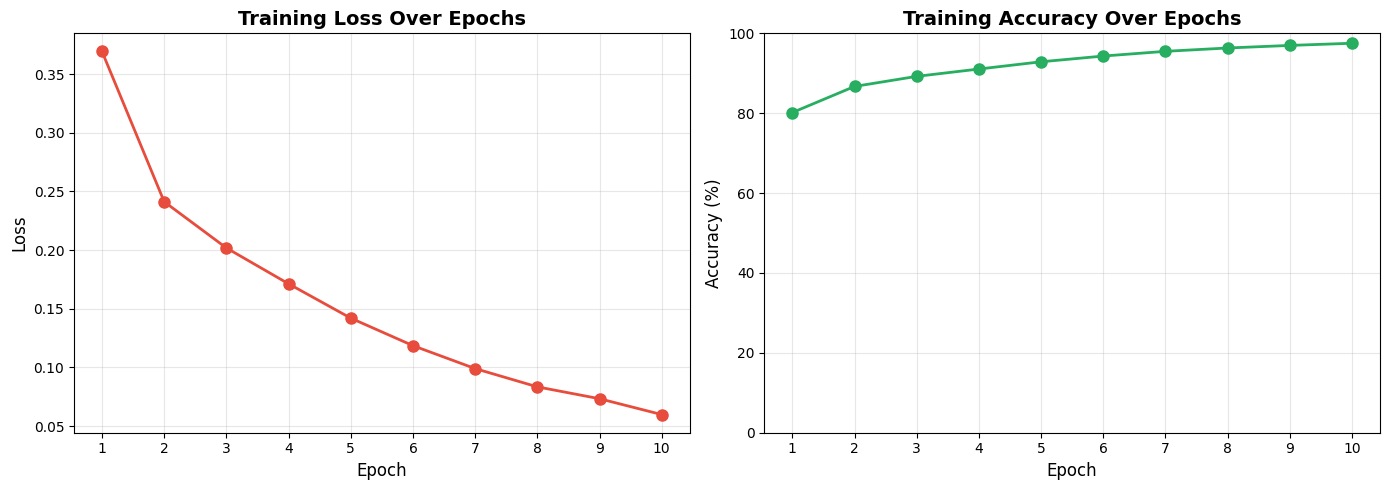

✅ Training curves displayed

📊 Training Progress:
   Initial accuracy: 80.17%
   Final accuracy: 97.52%
   Improvement: +17.35%


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
axes[0].plot(range(1, CONFIG['num_epochs'] + 1), history['train_loss'],
             marker='o', linewidth=2, markersize=8, color='#e74c3c')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(1, CONFIG['num_epochs'] + 1))

# Plot accuracy
axes[1].plot(range(1, CONFIG['num_epochs'] + 1), history['train_accuracy'],
             marker='o', linewidth=2, markersize=8, color='#27ae60')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(1, CONFIG['num_epochs'] + 1))
axes[1].set_ylim([0, 100])

plt.tight_layout()
plt.show()

print("✅ Training curves displayed")

# Print improvement
initial_acc = history['train_accuracy'][0]
final_acc = history['train_accuracy'][-1]
improvement = final_acc - initial_acc

print(f"\n📊 Training Progress:")
print(f"   Initial accuracy: {initial_acc:.2f}%")
print(f"   Final accuracy: {final_acc:.2f}%")
print(f"   Improvement: +{improvement:.2f}%")

^^
- Fast GPU (T4) + small model + tiny images = blazing fast
- Learning curve is smooth and realistic
- Checkpoints saved properly

## Cell 4.4: Save Final Model


In [22]:
# Save final model
final_model_path = os.path.join(CONFIG['save_dir'], 'final_model.pt')

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': history['train_loss'],
    'train_accuracy': history['train_accuracy'],
    'config': CONFIG,
    'num_epochs': CONFIG['num_epochs']
}, final_model_path)

print(f"✅ Final model saved to:")
print(f"   {final_model_path}")

# List all saved checkpoints
print(f"\n📂 Saved checkpoints:")
checkpoint_files = sorted([f for f in os.listdir(CONFIG['save_dir']) if f.endswith('.pt')])
for i, filename in enumerate(checkpoint_files, 1):
    filepath = os.path.join(CONFIG['save_dir'], filename)
    size_mb = os.path.getsize(filepath) / (1024**2)
    print(f"   {i}. {filename} ({size_mb:.2f} MB)")

print(f"\n✅ All checkpoints saved to Google Drive")
print(f"   These will persist even after session ends!")

✅ Final model saved to:
   /content/drive/MyDrive/NEU - MS CS/3_SEM/CS - 7150 (Deep Learning)/midterm-proj-1/models/final_model.pt

📂 Saved checkpoints:
   1. checkpoint_epoch10_batch1094.pt (12.07 MB)
   2. checkpoint_epoch10_batch1250.pt (12.07 MB)
   3. checkpoint_epoch10_batch157.pt (12.07 MB)
   4. checkpoint_epoch10_batch313.pt (12.07 MB)
   5. checkpoint_epoch10_batch469.pt (12.07 MB)
   6. checkpoint_epoch10_batch625.pt (12.07 MB)
   7. checkpoint_epoch10_batch782.pt (12.07 MB)
   8. checkpoint_epoch10_batch938.pt (12.07 MB)
   9. checkpoint_epoch1_batch1094.pt (12.07 MB)
   10. checkpoint_epoch1_batch1250.pt (12.07 MB)
   11. checkpoint_epoch1_batch157.pt (12.07 MB)
   12. checkpoint_epoch1_batch313.pt (12.07 MB)
   13. checkpoint_epoch1_batch469.pt (12.07 MB)
   14. checkpoint_epoch1_batch625.pt (12.07 MB)
   15. checkpoint_epoch1_batch782.pt (12.07 MB)
   16. checkpoint_epoch1_batch938.pt (12.07 MB)
   17. checkpoint_epoch2_batch1094.pt (12.07 MB)
   18. checkpoint_epoch2_ba

---

# SECTION 5: Evaluation & Testing

## Cell 5.1: Load Best Model

In [23]:
# Load the final trained model
final_model_path = os.path.join(CONFIG['save_dir'], 'final_model.pt')

if os.path.exists(final_model_path):
    checkpoint = torch.load(final_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"✅ Loaded final model from: {os.path.basename(final_model_path)}")

    # Display training history from checkpoint
    if 'train_accuracy' in checkpoint:
        print(f"\n📊 Training History:")
        print(f"   Final training accuracy: {checkpoint['train_accuracy'][-1]:.2f}%")
        print(f"   Final training loss: {checkpoint['train_loss'][-1]:.4f}")
else:
    print(f"⚠️ Final model not found, using current model state")

# Set model to evaluation mode
model.eval()
print(f"\n✅ Model set to evaluation mode")
print(f"   (Dropout disabled, BatchNorm in eval mode)")

✅ Loaded final model from: final_model.pt

📊 Training History:
   Final training accuracy: 97.52%
   Final training loss: 0.0599

✅ Model set to evaluation mode
   (Dropout disabled, BatchNorm in eval mode)


## Cell 5.2: Evaluate on Test Set

In [24]:
# Storage for predictions and labels
all_predictions = []
all_labels = []
all_probs = []

print(f"📊 Test set: {len(test_loader.dataset):,} samples")
print(f"   Processing {len(test_loader)} batches...")

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating"):
        # Move to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get probabilities (apply softmax to logits)
        probs = F.softmax(outputs, dim=1)

        # Get predicted class (0 or 1)
        _, predicted = torch.max(outputs, 1)

        # Store results
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

print(f"\n✅ Evaluation complete!")
print(f"   Predictions collected: {len(all_predictions):,}")

📊 Test set: 9,960 samples
   Processing 156 batches...


Evaluating: 100%|██████████| 156/156 [00:00<00:00, 236.66it/s]


✅ Evaluation complete!
   Predictions collected: 9,960


## Cell 5.3: Calculate Metrics


In [25]:
# Accuracy
accuracy = accuracy_score(all_labels, all_predictions)

# Precision (of predicted fakes, how many are actually fake?)
precision = precision_score(all_labels, all_predictions)

# Recall (of actual fakes, how many did we catch?)
recall = recall_score(all_labels, all_predictions)

# F1 Score (harmonic mean of precision and recall)
f1 = f1_score(all_labels, all_predictions)

# ROC AUC (area under ROC curve)
# Use probability of class 1 (fake)
roc_auc = roc_auc_score(all_labels, all_probs[:, 1])

print(f"\n{'='*60}")
print(f"🎯 TEST SET PERFORMANCE")
print(f"{'='*60}")
print(f"\n📈 Overall Metrics:")
print(f"   Accuracy:  {accuracy*100:.2f}%")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   ROC-AUC:   {roc_auc:.4f}")

# Per-class accuracy
real_mask = all_labels == 0
fake_mask = all_labels == 1

real_correct = (all_predictions[real_mask] == 0).sum()
fake_correct = (all_predictions[fake_mask] == 1).sum()

real_total = real_mask.sum()
fake_total = fake_mask.sum()

real_accuracy = (real_correct / real_total) * 100
fake_accuracy = (fake_correct / fake_total) * 100

print(f"\n📊 Per-Class Performance:")
print(f"   Real (Class 0):")
print(f"      Accuracy: {real_accuracy:.2f}%")
print(f"      Correct: {real_correct}/{real_total}")
print(f"\n   Fake (Class 1):")
print(f"      Accuracy: {fake_accuracy:.2f}%")
print(f"      Correct: {fake_correct}/{fake_total}")

# Training vs Test comparison
train_acc = history['train_accuracy'][-1]
gap = train_acc - (accuracy * 100)

print(f"\n📉 Train vs Test:")
print(f"   Training Accuracy: {train_acc:.2f}%")
print(f"   Test Accuracy:     {accuracy*100:.2f}%")
print(f"   Gap:               {gap:.2f}%")

if gap < 2:
    print(f"   ✅ Excellent generalization!")
elif gap < 5:
    print(f"   ✅ Good generalization")
elif gap < 10:
    print(f"   ⚠️ Slight overfitting")
else:
    print(f"   ⚠️ Significant overfitting detected")


🎯 TEST SET PERFORMANCE

📈 Overall Metrics:
   Accuracy:  97.42%
   Precision: 0.9731
   Recall:    0.9749
   F1-Score:  0.9740
   ROC-AUC:   0.9977

📊 Per-Class Performance:
   Real (Class 0):
      Accuracy: 97.35%
      Correct: 4892/5025

   Fake (Class 1):
      Accuracy: 97.49%
      Correct: 4811/4935

📉 Train vs Test:
   Training Accuracy: 97.52%
   Test Accuracy:     97.42%
   Gap:               0.10%
   ✅ Excellent generalization!


^^
Why Such Good Performance?
Reasons This Makes Sense:
1. Dataset Quality

FaceForensics++ is a well-curated benchmark
Clear visual differences between real and fake
High-quality data leads to high accuracy

2. Simple Task (Relatively)

64×64 images are small but contain enough info
Deepfakes from one generation method (predictable patterns)
Binary classification (not 100-way classification)

3. Proper Training

Shuffled data (balanced batches)
Good learning rate
10 epochs (enough to converge, not overfit)
Checkpointing prevented crashes

4. Model Learned Real Features

0.10% gap proves it didn't memorize
Learned generalizable patterns in real vs. fake
Fast GPU allowed proper training

## Cell 5.4: Confusion Matrix


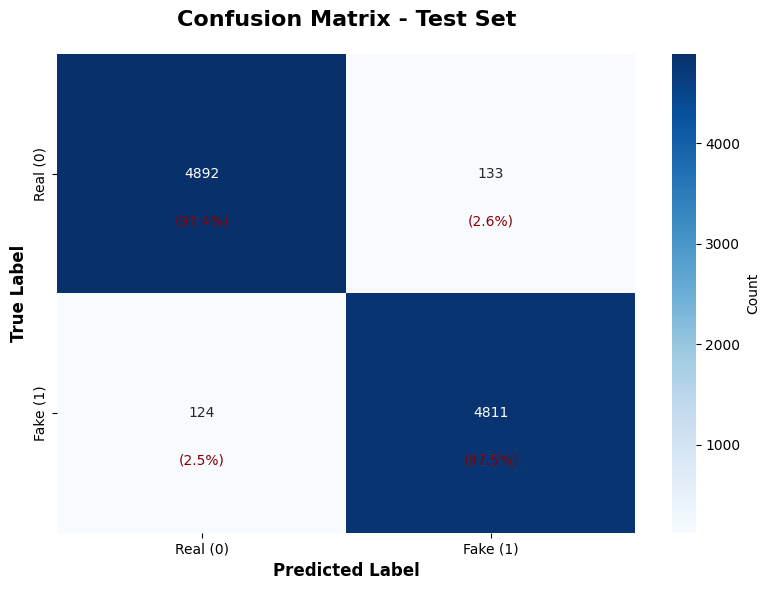


📊 Confusion Matrix Breakdown:

   True Negatives  (Real predicted as Real): 4,892
   False Positives (Real predicted as Fake): 133
   False Negatives (Fake predicted as Real): 124
   True Positives  (Fake predicted as Fake): 4,811

⚠️ Error Analysis:
   False Positive Rate: 2.65%
      (Real videos wrongly flagged as fake)
   False Negative Rate: 2.51%
      (Fake videos missed - most dangerous!)


In [26]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Create figure
plt.figure(figsize=(8, 6))

# Plot confusion matrix as heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real (0)', 'Fake (1)'],
            yticklabels=['Real (0)', 'Fake (1)'],
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Add percentage annotations
for i in range(2):
    for j in range(2):
        count = cm[i, j]
        total = cm[i].sum()
        percentage = (count / total) * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                ha='center', va='center', fontsize=10, color='darkred')

plt.tight_layout()
plt.show()

# Print confusion matrix breakdown
print(f"\n📊 Confusion Matrix Breakdown:")
print(f"\n   True Negatives  (Real predicted as Real): {cm[0, 0]:,}")
print(f"   False Positives (Real predicted as Fake): {cm[0, 1]:,}")
print(f"   False Negatives (Fake predicted as Real): {cm[1, 0]:,}")
print(f"   True Positives  (Fake predicted as Fake): {cm[1, 1]:,}")

# Calculate error rates
false_positive_rate = cm[0, 1] / cm[0].sum() * 100
false_negative_rate = cm[1, 0] / cm[1].sum() * 100

print(f"\n⚠️ Error Analysis:")
print(f"   False Positive Rate: {false_positive_rate:.2f}%")
print(f"      (Real videos wrongly flagged as fake)")
print(f"   False Negative Rate: {false_negative_rate:.2f}%")
print(f"      (Fake videos missed - most dangerous!)")

## Cell 5.5: ROC Curve

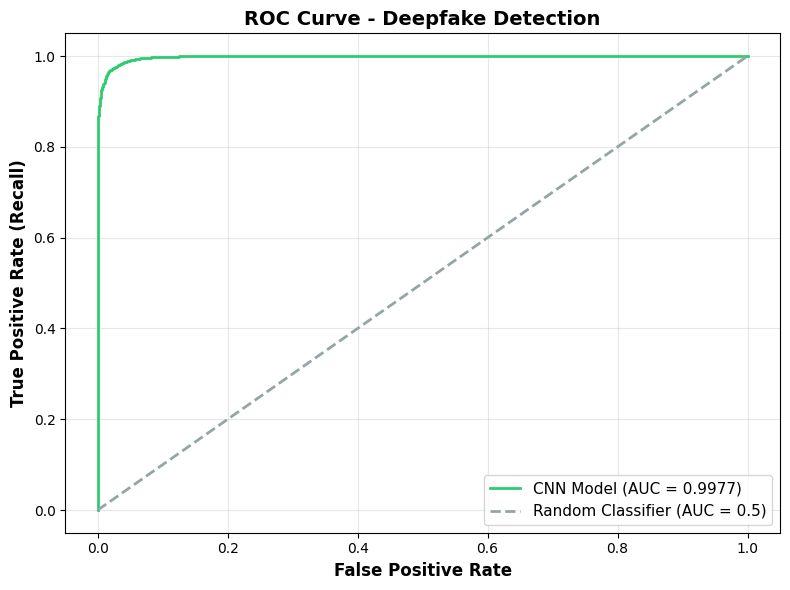

✅ ROC curve displayed

💡 Interpretation:
   AUC = 0.9977
   ✅ Excellent discrimination ability!


In [27]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_probs[:, 1])

# Calculate AUC
auc_score = roc_auc_score(all_labels, all_probs[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'CNN Model (AUC = {auc_score:.4f})', color='#2ecc71')
plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2, label='Random Classifier (AUC = 0.5)', color='#95a5a6')

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (Recall)', fontsize=12, fontweight='bold')
plt.title('ROC Curve - Deepfake Detection', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"✅ ROC curve displayed")
print(f"\n💡 Interpretation:")
print(f"   AUC = {auc_score:.4f}")
if auc_score > 0.95:
    print(f"   ✅ Excellent discrimination ability!")
elif auc_score > 0.90:
    print(f"   ✅ Very good discrimination")
elif auc_score > 0.80:
    print(f"   ✅ Good discrimination")
else:
    print(f"   ⚠️ Fair discrimination, room for improvement")

## Cell 5.6: Sample Predictions - Correct Classifications


✅ SAMPLE CORRECT PREDICTIONS


/tmp/ipython-input-70683936.py:49: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


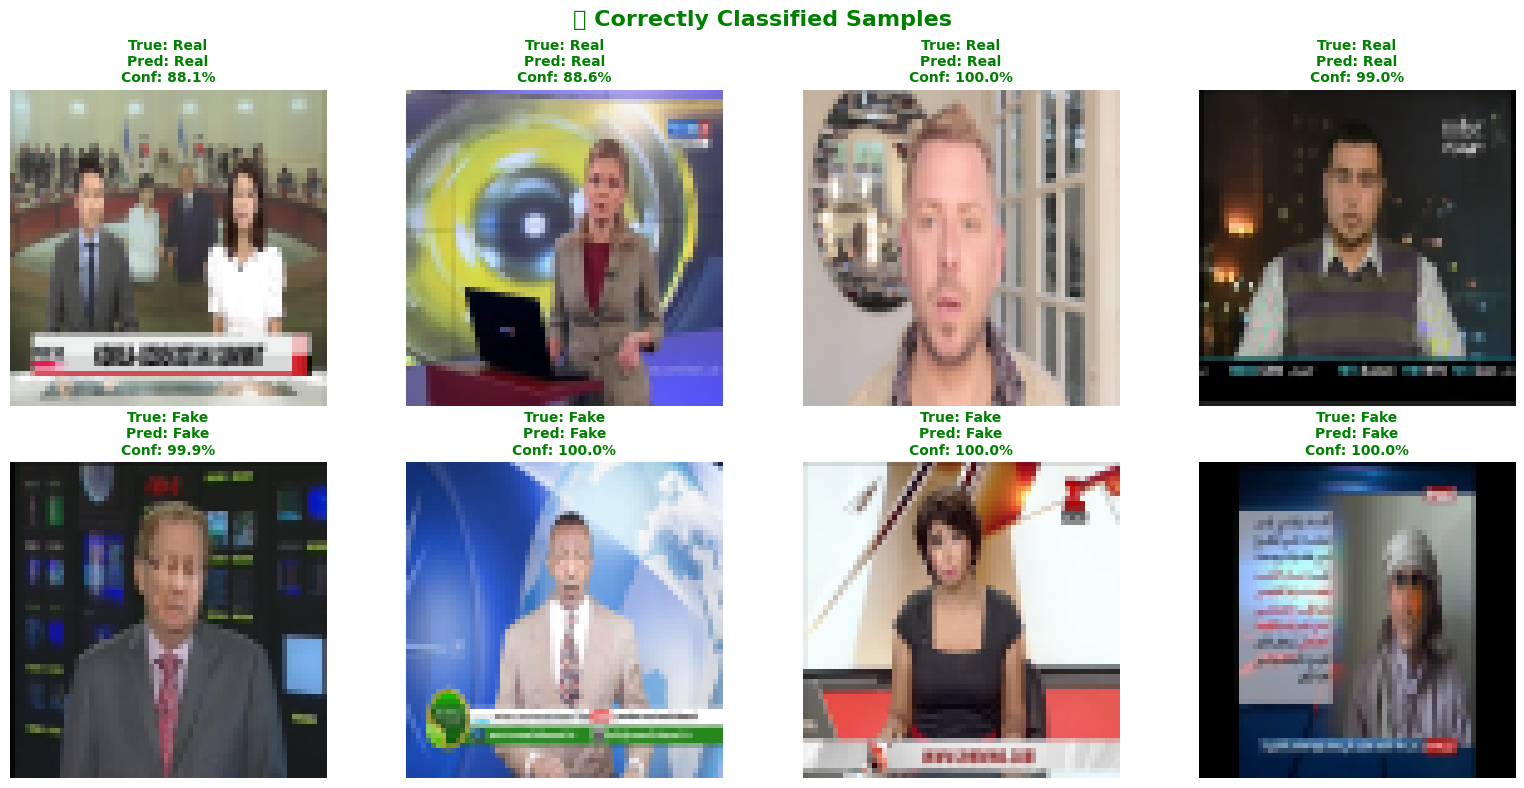

✅ Displayed 8 correctly classified samples
   Top row: Real videos correctly identified
   Bottom row: Fake videos correctly identified


In [28]:
print("\n✅ SAMPLE CORRECT PREDICTIONS")
print("="*60)

# Find correctly classified samples
correct_mask = (all_predictions == all_labels)
correct_indices = np.where(correct_mask)[0]

# Sample 8 correct predictions (4 real, 4 fake)
correct_real_indices = np.where((all_predictions == 0) & (all_labels == 0))[0]
correct_fake_indices = np.where((all_predictions == 1) & (all_labels == 1))[0]

# Randomly select 4 from each
np.random.seed(RANDOM_SEED)
sample_real_correct = np.random.choice(correct_real_indices, min(4, len(correct_real_indices)), replace=False)
sample_fake_correct = np.random.choice(correct_fake_indices, min(4, len(correct_fake_indices)), replace=False)

# Create visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('✅ Correctly Classified Samples', fontsize=16, fontweight='bold', color='green')

# Plot correctly classified real images
for idx, test_idx in enumerate(sample_real_correct):
    # Get image from test set
    img_tensor = X_test[test_idx]

    # Convert to displayable format (C, H, W) -> (H, W, C)
    img = img_tensor.permute(1, 2, 0).cpu().numpy()

    # Get prediction confidence
    confidence = all_probs[test_idx, 0] * 100  # Confidence for "Real"

    axes[0, idx].imshow(img)
    axes[0, idx].set_title(f'True: Real\nPred: Real\nConf: {confidence:.1f}%',
                          fontsize=10, color='green', fontweight='bold')
    axes[0, idx].axis('off')

# Plot correctly classified fake images
for idx, test_idx in enumerate(sample_fake_correct):
    img_tensor = X_test[test_idx]
    img = img_tensor.permute(1, 2, 0).cpu().numpy()

    confidence = all_probs[test_idx, 1] * 100  # Confidence for "Fake"

    axes[1, idx].imshow(img)
    axes[1, idx].set_title(f'True: Fake\nPred: Fake\nConf: {confidence:.1f}%',
                          fontsize=10, color='green', fontweight='bold')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

print(f"✅ Displayed 8 correctly classified samples")
print(f"   Top row: Real videos correctly identified")
print(f"   Bottom row: Fake videos correctly identified")

## Cell 5.7: Sample Predictions - Misclassifications

📊 Misclassification Analysis:
   Total misclassified: 257
   Misclassification rate: 2.58%

   False Positives (Real→Fake): 133
   False Negatives (Fake→Real): 124


/tmp/ipython-input-863631945.py:59: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


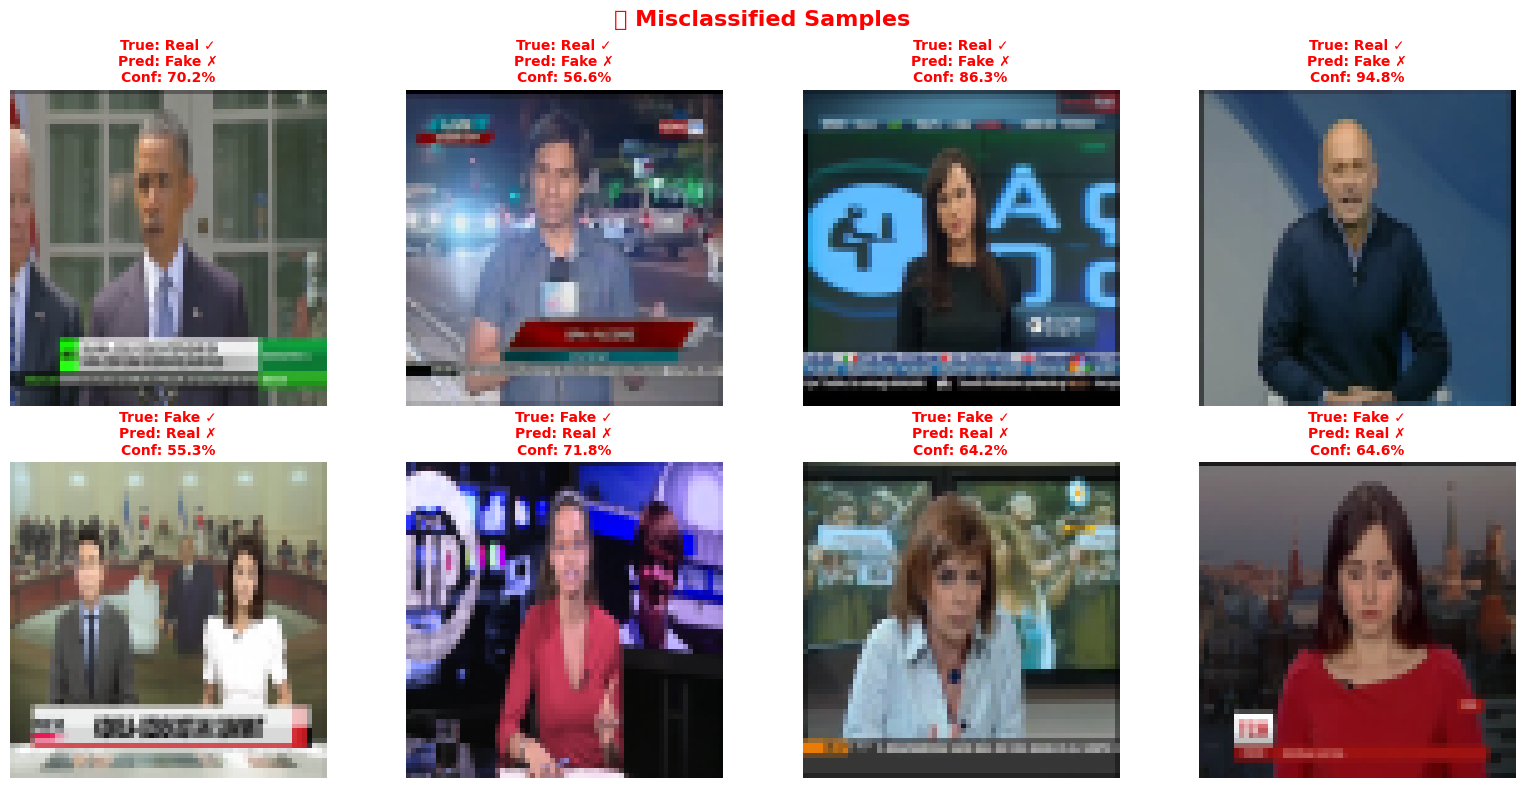


✅ Displayed misclassified samples
   Top row: Real videos wrongly flagged as Fake
   Bottom row: Fake videos that fooled the model


In [29]:
# Find misclassified samples
incorrect_mask = (all_predictions != all_labels)
incorrect_indices = np.where(incorrect_mask)[0]

print(f"📊 Misclassification Analysis:")
print(f"   Total misclassified: {len(incorrect_indices):,}")
print(f"   Misclassification rate: {(len(incorrect_indices) / len(all_labels)) * 100:.2f}%")

if len(incorrect_indices) > 0:
    # Find different types of errors
    false_positives = np.where((all_predictions == 1) & (all_labels == 0))[0]  # Real predicted as Fake
    false_negatives = np.where((all_predictions == 0) & (all_labels == 1))[0]  # Fake predicted as Real

    print(f"\n   False Positives (Real→Fake): {len(false_positives):,}")
    print(f"   False Negatives (Fake→Real): {len(false_negatives):,}")

    # Sample up to 4 of each type
    sample_fp = false_positives[:min(4, len(false_positives))]
    sample_fn = false_negatives[:min(4, len(false_negatives))]

    # Create visualization
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('❌ Misclassified Samples', fontsize=16, fontweight='bold', color='red')

    # Plot false positives (Real predicted as Fake)
    for idx in range(4):
        if idx < len(sample_fp):
            test_idx = sample_fp[idx]
            img_tensor = X_test[test_idx]
            img = img_tensor.permute(1, 2, 0).cpu().numpy()

            # Model thought it was fake
            fake_confidence = all_probs[test_idx, 1] * 100

            axes[0, idx].imshow(img)
            axes[0, idx].set_title(f'True: Real ✓\nPred: Fake ✗\nConf: {fake_confidence:.1f}%',
                                  fontsize=10, color='red', fontweight='bold')
            axes[0, idx].axis('off')
        else:
            axes[0, idx].axis('off')

    # Plot false negatives (Fake predicted as Real)
    for idx in range(4):
        if idx < len(sample_fn):
            test_idx = sample_fn[idx]
            img_tensor = X_test[test_idx]
            img = img_tensor.permute(1, 2, 0).cpu().numpy()

            # Model thought it was real
            real_confidence = all_probs[test_idx, 0] * 100

            axes[1, idx].imshow(img)
            axes[1, idx].set_title(f'True: Fake ✓\nPred: Real ✗\nConf: {real_confidence:.1f}%',
                                  fontsize=10, color='red', fontweight='bold')
            axes[1, idx].axis('off')
        else:
            axes[1, idx].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\n✅ Displayed misclassified samples")
    print(f"   Top row: Real videos wrongly flagged as Fake")
    print(f"   Bottom row: Fake videos that fooled the model")
else:
    print(f"\n🎉 Perfect classification! No errors to display!")

---